In [1]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift, fft, ifft
import soundfile as sf
from scipy.signal import hann
from CircularBuffer import CircularBuffer, StereoDelay


#KYW inst
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')

# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


## Delaying allpass filter reverberator

In [2]:
#Implementation from pirkles book

delayTime = 0.07
delaySamples = delayTime * fs

g = 0.6

delayLine = StereoDelay(delaySamples, delaySamples)

output = np.zeros((len(data), 2))

for i in range(len(data)):
    delayed = delayLine.get_samples_from_buffer()

    delayLine.push_samples_to_buffer(data[i] + np.multiply(delayed, g))

    output[i] = (-g * data[i]) + np.multiply((1 - pow(g,2)), delayed)


#Normalisation
max_amplitude = np.max(np.abs(output))
normalized_audio = output / max_amplitude


In [3]:
sd.play(normalized_audio, fs)

## Impulse response of system

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_46663/2450523449.py:2: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(len(data))


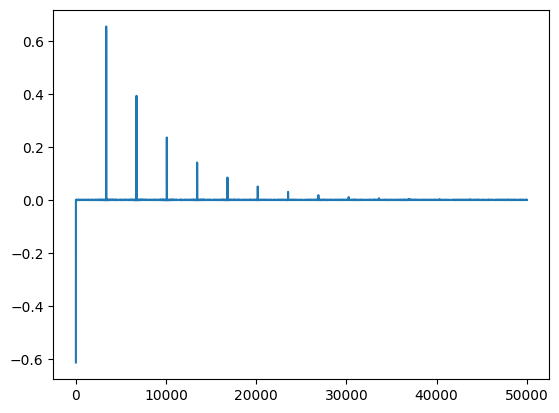

In [24]:
# Apply windowing
window = hann(len(data))
original_signal = data[:,0] * window
filtered_signal = normalized_audio[:,0] * window

original_spectrum = fft(original_signal)
filtered_spectrum = fft(filtered_signal)

epsilon = 1e-10

impulse_response_spectrum = filtered_spectrum/(original_spectrum + epsilon)

impulse_response = np.real(ifft(impulse_response_spectrum))

plt.plot(impulse_response[0:50000])

## Convolving data with the impulse response
Exact same result, but much less computationally efficient

In [28]:
impulse_response_conv = impulse_response[0:40000]

ex_L = np.convolve(data[:,0], impulse_response)
ex_R = np.convolve(data[:,1], impulse_response)

In [29]:
output_conv = np.vstack((ex_L, ex_R))
output_conv = output_conv.T

In [33]:
sd.play(output_conv)